In [1]:
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import Aer
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram

import numpy as np
from scipy.optimize import minimize

In [2]:
# dij需求i到设施j的成本
d = [[1, 2], [1, 2]]
n = 2   # 两个设施点
m = 2   # 两个需求点
# d = [[1, 2], [3, 4], [5, 6]]
# n = 2   # 两个设施点
# m = 3   # 三个需求点
num_qubits = n + 2 * n * m

# gi设施i的建设成本
g = [2, 1]


In [3]:
penalty = 35
depth = 6
params = np.ones(depth * 2)

In [4]:
# dtype=np.complex128
def add_in_target(num_qubits, target_qubit, gate=np.array([[1, 0],[0, -1]])):
    H = np.eye(2 ** (target_qubit))
    H = np.kron(H, gate)
    H = np.kron(H, np.eye(2 ** (num_qubits - 1 - target_qubit)))
    return H


def generate_Hp(n, m, d, g):
    # 初始化 Hp 矩阵为零矩阵
    # print(num_qubits)
    Hp = np.zeros((2**num_qubits, 2**num_qubits))
    for i in range(m):
        for j in range(n):
            Hp += d[i][j] * (add_in_target(num_qubits, n * (1 + i) + j) - np.eye(2**num_qubits)) / 2
    
    for j in range(n):
        Hp +=  g[j] * (add_in_target(num_qubits, j)- np.eye(2**num_qubits)) / 2

    for i in range(m):
        Ht = np.zeros((2**num_qubits, 2**num_qubits))
        for j in range(n):
            Ht += (np.eye(2**num_qubits) - add_in_target(num_qubits, n * (1 + i) + j)) / 2
        Ht -= np.eye(2**num_qubits)
        Hp += -penalty * Ht @ Ht
    
    for i in range(m):
        for j in range(n):
            Ht = (np.eye(2**num_qubits) - add_in_target(num_qubits, n * (1 + i) + j)) / 2 + (np.eye(2**num_qubits) - add_in_target(num_qubits, n * (1 + m + i) + j)) / 2 + (np.eye(2**num_qubits) - add_in_target(num_qubits, j)) / 2
            Hp += -penalty * Ht @ Ht

    return Hp

In [5]:
from scipy.linalg import expm
def build_circ(n, m, d, g, params):
  qc = QuantumCircuit(num_qubits)
  beta = params[:depth + 1]
  gamma = params[depth:]
  for i in range(num_qubits):
    qc.h(i)
  for dp in range(depth):
    qc.unitary(expm(-1j * gamma[dp] * generate_Hp(n, m, d, g)), range(num_qubits)) # transpile
    for i in range(num_qubits):
      qc.rx(beta[dp], i)
  qc.measure_all()
  return qc

In [6]:
def cost_function(x):
  num = [int(char) for char in x]
  C = 0
  for i in range(m):
    for j in range(n):
      C += d[i][j] * num[n * (1 + i) + j]
      
  for j in range(n):
    C += g[j] * num[j]

  for i in range(m):
    t = 0
    for j in range(n):
      t += num[n * (1 + i) + j]
    C += penalty * (t - 1)**2

  for i in range(m):
    for j in range(n):
      C += penalty * (num[n * (1 + i) + j] + num[n * (1 + m + i) + j] - num[j]) ** 2
  return C

def compute_expectation(counts):
  EV = 0
  total_count = 0
  for x, count in counts.items():
    C = cost_function(x)
    EV += C*count
    total_count += count

  return EV/total_count


def expectation_from_sample(shots = 2000):
  backend = Aer.get_backend('qasm_simulator')
  backend.shots = shots

  def execute_circ(theta):
    qc = build_circ(n, m, d, g, theta)
    counts = backend.run(qc, seed_simulator=10, shots=shots).result().get_counts()
    return compute_expectation(counts)
  
  return execute_circ

In [7]:
result_list = []

In [8]:
from numpy.lib.utils import source
from scipy.optimize import minimize
import numpy as np
# 初始化迭代计数器
iteration_count = 0
def test(pen, dep, par):
  global penalty, depth, params, iteration_count
  iteration_count = 0
  penalty = pen
  depth = dep
  params = par
  expectation = expectation_from_sample()
  def callback(x):
      global iteration_count
      iteration_count += 1
      if iteration_count % 10 == 0:
          print(f"Iteration {iteration_count}, Result: {expectation(x)}")
  # 设定最大迭代次数
  max_iterations = 1000

  # 使用 COBYLA 方法进行最小化，并设置 callback 函数
  res = minimize(expectation, params, method='COBYLA', options={'maxiter': max_iterations})
  # 输出最终结果
  print("Final Result:", res)
  backend = Aer.get_backend('aer_simulator')
  backend.shots = 100000

  shots=100000
  qc_res = build_circ(n, m, d, g, params=res.x)

  counts = backend.run(qc_res, seed_simulator=10, shots = shots).result().get_counts()
  # plot_histogram(counts)
  sorted_counts = sorted(counts, key=counts.get, reverse=True)
  print("\n----------------- Full result ---------------------")
  print("selection\t\tprobability\tvalue")
  print("---------------------------------------------------")
  for x in sorted_counts:
    if cost_function(x) == 4:
      result_list.append(counts[x] / shots * 100)
      print(x, "{:.1f}%".format(counts[x] / shots * 100), cost_function(x))

In [9]:
import time
times = []

for i in range(1, 16):
    print(f'depth == {i}')
    start_time = time.time()  # 记录开始时间
    test(35, i, np.full(i * 2, np.pi/3))
    end_time = time.time()  # 记录结束时间
    elapsed_time = end_time - start_time  # 计算执行时间
    times.append(elapsed_time)  # 将执行时间添加到列表中

print("Execution times:", times)

depth == 1
Final Result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 116.9905
       x: [ 1.515e+00  1.876e+00]
    nfev: 36
   maxcv: 0.0

----------------- Full result ---------------------
selection		probability	value
---------------------------------------------------
1010100000 0.1% 4
depth == 2
Final Result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 109.4215
       x: [ 1.558e+00  9.904e-01  2.058e+00  1.049e+00]
    nfev: 47
   maxcv: 0.0

----------------- Full result ---------------------
selection		probability	value
---------------------------------------------------
1010100000 0.0% 4
depth == 3
Final Result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 135.6375
       x: [ 1.048e+00  2.054e+00  1.045e+00  2.047e+00  2.052e+00
            2.049e+00]
    nfev: 70
   maxcv: 0.0

----------------- Full result ---------------------
selection		probability	val

In [11]:
result_list

[0.104,
 0.01,
 0.149,
 0.077,
 0.393,
 1.2109999999999999,
 0.213,
 5.128,
 0.109,
 0.192,
 0.49300000000000005,
 0.029,
 0.5,
 0.33899999999999997,
 0.415]

In [60]:
times

[13.597586870193481,
 33.110121965408325,
 67.163982629776,
 115.49887156486511,
 140.03667378425598,
 239.79148125648499,
 250.6837432384491,
 327.8976855278015,
 330.5476498603821,
 417.3265149593353,
 502.75129866600037,
 501.88908529281616,
 589.0639977455139,
 772.0837121009827,
 850.3826575279236]

In [15]:
result = result_list

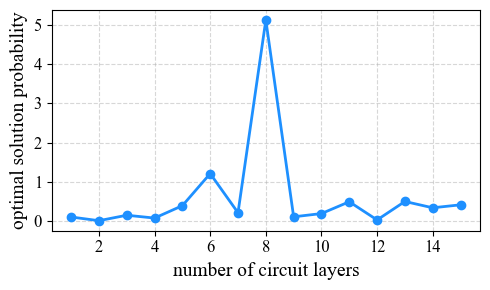

In [61]:
import matplotlib.pyplot as plt

# x轴数据
x = range(1, 16)

# 绘制折线图
plt.rcParams['font.family'] = 'Times New Roman'  # 设置字体
plt.figure(figsize=(5, 3))  # 设置图形尺寸
plt.grid(True, linestyle='--', alpha=0.5)  # 显示网格线


plt.plot(x, result_list, marker='o', color='dodgerblue', linewidth=2, markersize=6)

# 设置标题和标签
plt.xlabel('number of circuit layers', fontsize=14)
plt.ylabel('optimal solution probability', fontsize=14)

# 设置刻度字体
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 调整网格线显示顺序
plt.gca().set_axisbelow(True)
plt.ylim()
# 显示图形
plt.tight_layout()
plt.savefig("test.svg", format="svg")  # 保存图形
plt.show()


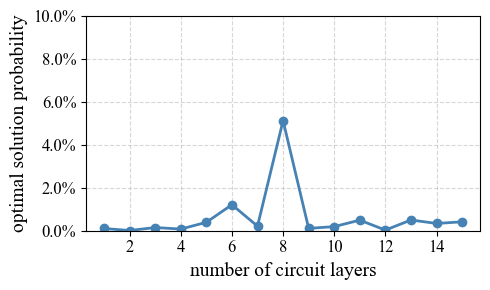

In [58]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# x轴数据
x = range(1, 16)

# 绘制折线图
plt.rcParams['font.family'] = 'Times New Roman'  # 设置字体
plt.figure(figsize=(5, 3))  # 设置图形尺寸
plt.grid(True, linestyle='--', alpha=0.5)  # 显示网格线

# 绘制折线图
plt.plot(x, result_list, marker='o', color='steelblue', linewidth=2, markersize=6)

# 设置标题和标签
plt.xlabel('number of circuit layers', fontsize=14)
plt.ylabel('optimal solution probability', fontsize=14)

# 设置刻度字体
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 调整网格线显示顺序
plt.gca().set_axisbelow(True)

# 修改边框颜色
# plt.gca().spines['bottom'].set_color('navy')
# plt.gca().spines['top'].set_color('navy')
# plt.gca().spines['left'].set_color('navy')
# plt.gca().spines['right'].set_color('navy')

# 设置 y 轴范围和百分比刻度
plt.ylim(0, 10)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))

# 显示图形
plt.tight_layout()
plt.savefig("9_1_16_p.svg", format="svg")  # 保存图形
plt.show()


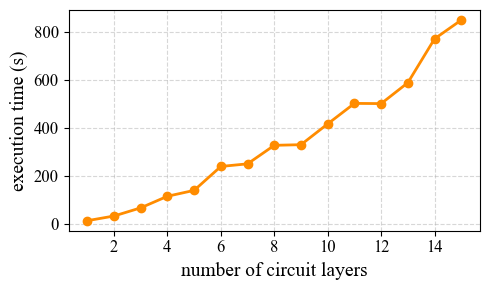

In [62]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# x轴数据
x = range(1, 16)

# 绘制折线图
plt.rcParams['font.family'] = 'Times New Roman'  # 设置字体
plt.figure(figsize=(5, 3))  # 设置图形尺寸
plt.grid(True, linestyle='--', alpha=0.5)  # 显示网格线

# 绘制折线图
plt.plot(x, times, marker='o', color='darkorange', linewidth=2, markersize=6)

# 设置标题和标签
plt.xlabel('number of circuit layers', fontsize=14)
plt.ylabel('execution time (s)', fontsize=14)

# 设置刻度字体
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 调整网格线显示顺序
plt.gca().set_axisbelow(True)


# 设置 y 轴范围和百分比刻度
# plt.ylim(0, 10)
# plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))

# 显示图形
plt.tight_layout()
plt.savefig("9_1_16_s.svg", format="svg")  # 保存图形
plt.show()
